In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
# tf.enable_eager_execution()
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_probability
tfd = tensorflow_probability.distributions

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '/data2/cosmo4d/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200, 300, 400]
rprob = 0.95

In [3]:
suff = '-pad2'
num_cubes= 1000
cube_size = 32
pad = 2
cube_sizeft = cube_size + 2*pad
max_offset = ncp - cube_size
ftname = ['cic']
nchannels = len(ftname)

# Training data set

In [4]:
#############################
##Read data and generate meshes
#mesh = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/d/')
meshes = {}
cube_features, cube_target = [], []

for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    #mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    #mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    #mesh['GD'] = mesh['R1'] - mesh['R2']

    hmesh = {}
    hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
    hposd = tools.readbigfile(hpath + 'Position/')
    massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)*1e10
    galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
    #hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]    
    #hposd = hposall[:num].copy()
    #massd = massall[:num].copy()
    #hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    #hmesh['mnn'] = tools.paintnn(hposd, bs, ncp, massd)
    hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
    hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    ntarget = len(targetmesh)
    
    features, target = dtools.randomvoxels(ftlistpad, targetmesh, num_cubes, max_offset, cube_size, cube_sizeft,
                                           seed=seed, rprob=rprob)
    cube_features = cube_features + features
    cube_target = cube_target + target

#
cube_target = np.stack(cube_target,axis=0).reshape((-1,cube_size,cube_size,cube_size, ntarget))
cube_features = np.stack(cube_features,axis=0).reshape((-1,cube_sizeft,cube_sizeft,cube_sizeft,nchannels))
print(cube_target[0].shape)
print(cube_features[0].shape)
trainingsize = cube_features.shape[0]
print('Training size is = ', trainingsize)

All the mesh have been generated for seed = 100
Length of targets =  2
Supplemented by rotation :  951
All the mesh have been generated for seed = 200
Length of targets =  2
Supplemented by rotation :  944
All the mesh have been generated for seed = 300
Length of targets =  2
Supplemented by rotation :  938
All the mesh have been generated for seed = 400
Length of targets =  2
Supplemented by rotation :  948
(32, 32, 32, 2)
(36, 36, 36, 1)
Training size is =  7781


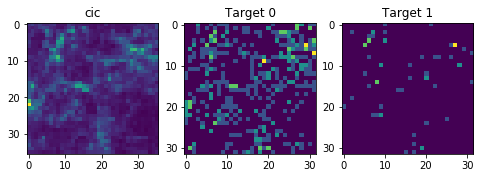

In [5]:
fig, ax = plt.subplots(1, nchannels+ntarget, figsize = (nchannels*4+4, 5))
n = 10
for i in range(nchannels):
    ax[i].imshow(cube_features[n][:,:,:,i].sum(axis=0))
    ax[i].set_title(ftname[i])
for j in range(ntarget):
    ax[i+j+1].imshow(cube_target[n][:,:,:,j].sum(axis=0))
    ax[i+j+1].set_title('Target %d'%j)
# ax[-1].imshow(cube_target[n][:,:,:,0].sum(axis=0))
# ax[-1].set_title('Target')

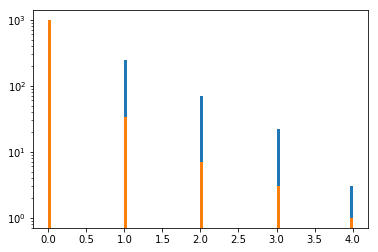

In [6]:
hist(cube_target[n][:,:,:,0].sum(axis=0).flatten(),100);
hist(cube_target[n][:,:,:,1].sum(axis=0).flatten(),100);
yscale('log')

In [7]:
tmp = cube_target[0][:, :, :, 1]
np.unique(tmp, return_counts=True)

(array([0., 1., 2., 3.]), array([32739,    23,     5,     1]))

# Model

In [8]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow_probability
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tensorflow_probability.distributions
tfd = tfp.distributions
tfb = tfp.bijectors

def _mdn_model_fn(features, labels, n_y, n_mixture, cube_size, dropout, optimizer, mode):

    # Check for training mode
    is_training = mode == tf.estimator.ModeKeys.TRAIN
        
    def _module_fn():
        """
        Function building the module
        """
    
        feature_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
        obs_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, n_y], name='observations')

        # Builds the neural network
        net = slim.conv3d(feature_layer, 16, 5, activation_fn=tf.nn.leaky_relu, padding='valid')
        net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
        net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
        net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu, keep_prob=dropout, is_training=is_training)
        net = slim.conv3d(net, 32, 3, activation_fn=tf.nn.tanh)

        # Define the probabilistic layer 
        net = slim.conv3d(net, n_mixture*3*n_y, 1, activation_fn=None)
        net = tf.reshape(net, [-1, cube_size, cube_size, cube_size, n_y, n_mixture*3])
        loc, unconstrained_scale, logits = tf.split(net,
                                                    num_or_size_splits=3,
                                                    axis=-1)
        scale = tf.nn.softplus(unconstrained_scale)

        # Form mixture of discretized logistic distributions. Note we shift the
        # logistic distribution by -0.5. This lets the quantization capture "rounding"
        # intervals, `(x-0.5, x+0.5]`, and not "ceiling" intervals, `(x-1, x]`.
        discretized_logistic_dist = tfd.QuantizedDistribution(
            distribution=tfd.TransformedDistribution(
                distribution=tfd.Logistic(loc=loc, scale=scale),
                bijector=tfb.AffineScalar(shift=-0.5)),
            low=0.,
            high=2**4 - 1.)

        mixture_dist = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(logits=logits),
            components_distribution=discretized_logistic_dist)

        # Define a function for sampling, and a function for estimating the log likelihood
        sample = tf.squeeze(mixture_dist.sample())
        loglik = mixture_dist.log_prob(obs_layer)
        hub.add_signature(inputs={'features':feature_layer, 'labels':obs_layer}, 
                          outputs={'sample':sample, 'loglikelihood':loglik})
    
    # Create model and register module if necessary
    spec = hub.create_module_spec(_module_fn)
    module = hub.Module(spec, trainable=True)
    if isinstance(features,dict):
        predictions = module(features, as_dict=True)
    else:
        predictions = module({'features':features, 'labels':labels}, as_dict=True)
    
    if mode == tf.estimator.ModeKeys.PREDICT:    
        hub.register_module_for_export(module, "likelihood")
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loglik = predictions['loglikelihood']
    # Compute and register loss function
    neg_log_likelihood = -tf.reduce_sum(loglik, axis=-1)
    neg_log_likelihood = tf.reduce_mean(neg_log_likelihood)
    
    tf.losses.add_loss(neg_log_likelihood)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

    train_op = None
    eval_metric_ops = None

    # Define optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer(learning_rate=0.00001).minimize(loss=total_loss,
                                        global_step=tf.train.get_global_step())
        tf.summary.scalar('loss', neg_log_likelihood)
    elif mode == tf.estimator.ModeKeys.EVAL:
        
        eval_metric_ops = { "log_p": neg_log_likelihood}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

class MDNEstimator(tf.estimator.Estimator):
    """An estimator for distribution estimation using Mixture Density Networks.
    """

    def __init__(self,
                 n_y,
                 n_mixture,
                 cube_size,
                 optimizer=tf.train.AdamOptimizer,
                 dropout=None,
                 model_dir=None,
                 config=None):
        """Initializes a `MDNEstimator` instance.
        """

        def _model_fn(features, labels, mode):
            return _mdn_model_fn(features, labels, 
                 n_y, n_mixture, cube_size, dropout,
                                 optimizer, mode)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [9]:
batch_size=32

def mapping_function(inds, rotate=True):
    def extract_batch(inds):
        features = cube_features[inds].astype('float32')
        targets = cube_target[inds].astype('float32')
        
        return features, targets
    ft, tg = tf.py_func(extract_batch, [inds],
                        [tf.float32, tf.float32])
    sft = cube_features.shape
    stg = cube_target.shape
    ft.set_shape((None,)+sft[1:]) 
    tg.set_shape((None,)+stg[1:])
    return ft, tg

def training_input_fn():
    """Serving input fn for training data"""
    dataset = tf.data.Dataset.range(len(cube_features))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    dataset = dataset.map(mapping_function)
    dataset = dataset.prefetch(16)
    return dataset

def testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.range(len(cube_features))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_function)
    return dataset

In [10]:
run_config = tf.estimator.RunConfig(save_checkpoints_steps = 1000)

model =  MDNEstimator(n_y=2, n_mixture=8, cube_size=cube_size, dropout=0.95,
                      model_dir='/data2/galmodel/models/model3', config = run_config)

INFO:tensorflow:Using config: {'_model_dir': '/data2/galmodel/models/model3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4e582d0eb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
# Trying to export
features = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
labels = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 2], name='observations')
    
exporter = hub.LatestModuleExporter("tf_hub", tf.estimator.export.build_raw_serving_input_receiver_fn({'features':features, 'labels':labels},
                                                                   default_batch_size=None))

In [12]:
exporter.export(model, 'models', model.latest_checkpoint())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Restoring parameters from /data2/galmodel/models/model3/model.ckpt-89000
INFO:tensorflow:Exported TF-Hub module to: b"models/temp-b'1544168303'/likelihood"


b'models/1544168303'

# Train

In [151]:
model.train(training_input_fn, max_steps=100000)

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/galmodel/models/model3/model.ckpt-33000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 33000 into /data2/galmodel/models/model3/model.ckpt.
INFO:tensorflow:loss = 0.024339829, step = 33000
INFO:tensorflow:global_step/sec: 1.46802
INFO:tensorflow:loss = 0.021800082, step = 33100 (68.120 sec)
INFO:tensorflow:global_step/sec: 1.46467
INFO:tensorflow:loss = 0.02236577, step = 33200 (68.276 sec)
INFO:tensorflow:global_step/sec: 1.4639
INFO:tensorflow:loss = 0.021725629, step = 33300 (68.310 sec)
INFO:tensorflow:global_step/sec: 1.45969
INFO:tensorflow:loss = 0.023281341, step = 33400 (68.507 sec)
INFO:tensorflow:global_step/sec: 1.46078
INFO:tensorflow:loss = 0.023103194, step = 33500 (68.457 sec)
INFO:tensorflow:global_step/sec: 1.46148
INFO:tensorfl

INFO:tensorflow:loss = 0.021312205, step = 40000 (69.968 sec)
INFO:tensorflow:global_step/sec: 1.46151
INFO:tensorflow:loss = 0.021055501, step = 40100 (68.422 sec)
INFO:tensorflow:global_step/sec: 1.46326
INFO:tensorflow:loss = 0.022741865, step = 40200 (68.340 sec)
INFO:tensorflow:global_step/sec: 1.46221
INFO:tensorflow:loss = 0.02199335, step = 40300 (68.389 sec)
INFO:tensorflow:global_step/sec: 1.46434
INFO:tensorflow:loss = 0.022692017, step = 40400 (68.291 sec)
INFO:tensorflow:global_step/sec: 1.46355
INFO:tensorflow:loss = 0.025044559, step = 40500 (68.327 sec)
INFO:tensorflow:global_step/sec: 1.46222
INFO:tensorflow:loss = 0.02363372, step = 40600 (68.389 sec)
INFO:tensorflow:global_step/sec: 1.46141
INFO:tensorflow:loss = 0.021233743, step = 40700 (68.427 sec)
INFO:tensorflow:global_step/sec: 1.46198
INFO:tensorflow:loss = 0.024130024, step = 40800 (68.400 sec)
INFO:tensorflow:global_step/sec: 1.46344
INFO:tensorflow:loss = 0.020668693, step = 40900 (68.332 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 1.46298
INFO:tensorflow:loss = 0.023035249, step = 47400 (68.353 sec)
INFO:tensorflow:global_step/sec: 1.46375
INFO:tensorflow:loss = 0.02099594, step = 47500 (68.319 sec)
INFO:tensorflow:global_step/sec: 1.46454
INFO:tensorflow:loss = 0.021690201, step = 47600 (68.280 sec)
INFO:tensorflow:global_step/sec: 1.46077
INFO:tensorflow:loss = 0.0213555, step = 47700 (68.457 sec)
INFO:tensorflow:global_step/sec: 1.46307
INFO:tensorflow:loss = 0.021498714, step = 47800 (68.350 sec)
INFO:tensorflow:global_step/sec: 1.46501
INFO:tensorflow:loss = 0.020350026, step = 47900 (68.259 sec)
INFO:tensorflow:Saving checkpoints for 48000 into /data2/galmodel/models/model3/model.ckpt.
INFO:tensorflow:global_step/sec: 1.42986
INFO:tensorflow:loss = 0.020901477, step = 48000 (69.937 sec)
INFO:tensorflow:global_step/sec: 1.46258
INFO:tensorflow:loss = 0.02096169, step = 48100 (68.372 sec)
INFO:tensorflow:global_step/sec: 1.46347
INFO:tensorflow:loss = 0.021850927, step = 4820

INFO:tensorflow:global_step/sec: 1.46279
INFO:tensorflow:loss = 0.022739377, step = 54800 (68.362 sec)
INFO:tensorflow:global_step/sec: 1.46422
INFO:tensorflow:loss = 0.024810404, step = 54900 (68.296 sec)
INFO:tensorflow:Saving checkpoints for 55000 into /data2/galmodel/models/model3/model.ckpt.
INFO:tensorflow:global_step/sec: 1.42903
INFO:tensorflow:loss = 0.022072127, step = 55000 (69.978 sec)
INFO:tensorflow:global_step/sec: 1.46343
INFO:tensorflow:loss = 0.022453018, step = 55100 (68.333 sec)
INFO:tensorflow:global_step/sec: 1.46189
INFO:tensorflow:loss = 0.020303424, step = 55200 (68.405 sec)
INFO:tensorflow:global_step/sec: 1.46338
INFO:tensorflow:loss = 0.021931563, step = 55300 (68.335 sec)
INFO:tensorflow:global_step/sec: 1.46217
INFO:tensorflow:loss = 0.021415908, step = 55400 (68.392 sec)
INFO:tensorflow:global_step/sec: 1.46295
INFO:tensorflow:loss = 0.022247896, step = 55500 (68.354 sec)
INFO:tensorflow:global_step/sec: 1.46321
INFO:tensorflow:loss = 0.021212092, step = 

INFO:tensorflow:global_step/sec: 1.46186
INFO:tensorflow:loss = 0.024540145, step = 62100 (68.406 sec)
INFO:tensorflow:global_step/sec: 1.4625
INFO:tensorflow:loss = 0.022037007, step = 62200 (68.377 sec)
INFO:tensorflow:global_step/sec: 1.4601
INFO:tensorflow:loss = 0.021507638, step = 62300 (68.488 sec)
INFO:tensorflow:global_step/sec: 1.46339
INFO:tensorflow:loss = 0.0224485, step = 62400 (68.335 sec)
INFO:tensorflow:global_step/sec: 1.4641
INFO:tensorflow:loss = 0.024941646, step = 62500 (68.301 sec)
INFO:tensorflow:global_step/sec: 1.46397
INFO:tensorflow:loss = 0.020366391, step = 62600 (68.307 sec)
INFO:tensorflow:global_step/sec: 1.46341
INFO:tensorflow:loss = 0.02057107, step = 62700 (68.333 sec)
INFO:tensorflow:global_step/sec: 1.46334
INFO:tensorflow:loss = 0.020595908, step = 62800 (68.337 sec)
INFO:tensorflow:global_step/sec: 1.46493
INFO:tensorflow:loss = 0.022393199, step = 62900 (68.263 sec)
INFO:tensorflow:Saving checkpoints for 63000 into /data2/galmodel/models/model3

INFO:tensorflow:global_step/sec: 1.46411
INFO:tensorflow:loss = 0.02440218, step = 69500 (68.301 sec)
INFO:tensorflow:global_step/sec: 1.4635
INFO:tensorflow:loss = 0.022970317, step = 69600 (68.329 sec)
INFO:tensorflow:global_step/sec: 1.46231
INFO:tensorflow:loss = 0.021571001, step = 69700 (68.384 sec)
INFO:tensorflow:global_step/sec: 1.46417
INFO:tensorflow:loss = 0.02030735, step = 69800 (68.300 sec)
INFO:tensorflow:global_step/sec: 1.46041
INFO:tensorflow:loss = 0.022121603, step = 69900 (68.473 sec)
INFO:tensorflow:Saving checkpoints for 70000 into /data2/galmodel/models/model3/model.ckpt.
INFO:tensorflow:global_step/sec: 1.42503
INFO:tensorflow:loss = 0.024415242, step = 70000 (70.174 sec)
INFO:tensorflow:global_step/sec: 1.46516
INFO:tensorflow:loss = 0.02525283, step = 70100 (68.252 sec)
INFO:tensorflow:global_step/sec: 1.46192
INFO:tensorflow:loss = 0.02161203, step = 70200 (68.403 sec)
INFO:tensorflow:global_step/sec: 1.46336
INFO:tensorflow:loss = 0.020185746, step = 70300

INFO:tensorflow:global_step/sec: 1.46285
INFO:tensorflow:loss = 0.021729015, step = 76900 (68.360 sec)
INFO:tensorflow:Saving checkpoints for 77000 into /data2/galmodel/models/model3/model.ckpt.
INFO:tensorflow:global_step/sec: 1.42783
INFO:tensorflow:loss = 0.022176303, step = 77000 (70.036 sec)
INFO:tensorflow:global_step/sec: 1.46447
INFO:tensorflow:loss = 0.025063977, step = 77100 (68.285 sec)
INFO:tensorflow:global_step/sec: 1.46205
INFO:tensorflow:loss = 0.019652067, step = 77200 (68.397 sec)
INFO:tensorflow:global_step/sec: 1.4644
INFO:tensorflow:loss = 0.022773568, step = 77300 (68.287 sec)
INFO:tensorflow:global_step/sec: 1.46448
INFO:tensorflow:loss = 0.021596776, step = 77400 (68.284 sec)
INFO:tensorflow:global_step/sec: 1.46267
INFO:tensorflow:loss = 0.024361173, step = 77500 (68.369 sec)
INFO:tensorflow:global_step/sec: 1.46462
INFO:tensorflow:loss = 0.020617925, step = 77600 (68.277 sec)
INFO:tensorflow:global_step/sec: 1.46331
INFO:tensorflow:loss = 0.02034698, step = 77

INFO:tensorflow:global_step/sec: 1.46196
INFO:tensorflow:loss = 0.021179171, step = 84200 (68.401 sec)
INFO:tensorflow:global_step/sec: 1.46433
INFO:tensorflow:loss = 0.024114452, step = 84300 (68.291 sec)
INFO:tensorflow:global_step/sec: 1.46495
INFO:tensorflow:loss = 0.0180712, step = 84400 (68.262 sec)
INFO:tensorflow:global_step/sec: 1.46353
INFO:tensorflow:loss = 0.022103377, step = 84500 (68.328 sec)
INFO:tensorflow:global_step/sec: 1.46452
INFO:tensorflow:loss = 0.022541894, step = 84600 (68.282 sec)
INFO:tensorflow:global_step/sec: 1.4622
INFO:tensorflow:loss = 0.022028038, step = 84700 (68.390 sec)
INFO:tensorflow:global_step/sec: 1.46462
INFO:tensorflow:loss = 0.020520119, step = 84800 (68.277 sec)
INFO:tensorflow:global_step/sec: 1.46218
INFO:tensorflow:loss = 0.02044284, step = 84900 (68.391 sec)
INFO:tensorflow:Saving checkpoints for 85000 into /data2/galmodel/models/model3/model.ckpt.
INFO:tensorflow:global_step/sec: 1.42861
INFO:tensorflow:loss = 0.021484375, step = 8500

KeyboardInterrupt: 

## Testing

In [126]:
# Define prediction function and extract samples for each example
pred = model.predict(testing_input_fn, yield_single_examples=False)
preds = np.concatenate([p['samples'] for p in pred],axis=0)

INFO:tensorflow:Calling model_fn.


/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/galmodel/models/model3/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


KeyboardInterrupt: 

In [127]:
preds.shape

(1479, 32, 32, 32, 2)

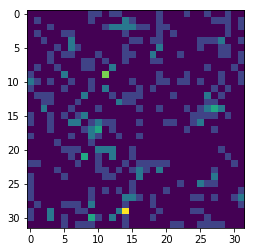

In [128]:
imshow(preds[0,:,:,:,0].sum(axis=-1))

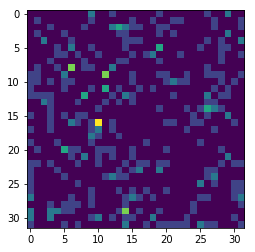

In [129]:
imshow(cube_target[0,:,:,:,0].sum(axis=-1))

In [130]:
inds = np.random.choice(int(trainingsize), batch_size, replace=False)
input = cube_features[inds]
# ploss0, ploss1 = sess.run([loss0, loss1], feed_dict={x:input, ysat:cube_satellites[inds],
#                                                ywt:wts[inds], ycen:cube_centrals[inds] })

# print('Loss sat, loss cen :', ploss0, ploss1)

# ind = 10
# recp, recm, rates = sess.run([pdf.sample(), pred_mask, out_rate], feed_dict={x:input.reshape(1, *input.shape)})
rec = preds[inds]

recm = rec[:,:,:,:,0]
recp = rec[:,:,:,:,1]

ind = 10 
fig, axar = plt.subplots(2, 2, figsize=(10,10))
ax = axar[0]
ax[0].imshow(recm[ind, :,:,:].sum(axis=0),vmax=4 );
ax[0].set_title('predict cen')
im = ax[1].imshow(recp[ind,:,:,:].sum(axis=0),vmax=4 );
#plt.colorbar(im, ax=ax[1])
ax[1].set_title('predict sats')
ax = axar[1]
ax[0].imshow(cube_target[inds][ind,:,:,:,0].sum(axis=0),vmax=4);
ax[0].set_title('target cen')
im = ax[1].imshow(cube_target[inds][ind,:,:,:,1].sum(axis=0),vmax=4);
#plt.colorbar(im, ax=ax[1])
ax[1].set_title('target sat')
plt.show()

IndexError: index 4322 is out of bounds for axis 0 with size 1479

# Prediction

In [152]:
#############################
# meshes = {}
tseeds = [100,  400]

for seed in tseeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    
    hmesh = {}
    hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
    hposd = tools.readbigfile(hpath + 'Position/')
    massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)
    galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
    hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)
    hmesh['mnnsat'] = tools.paintnn(hposd[galtype], bs, ncp, massd[galtype])
    hmesh['mnncen'] = tools.paintnn(hposd[~galtype], bs, ncp, massd[~galtype])

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    ntarget = len(targetmesh)

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube).astype('float32')
    
    def serving_input_fn():
        """Serving input fn for testing data"""
        dataset = tf.data.Dataset.from_tensor_slices(inp)
        dataset = dataset.batch(16)
        return dataset
    pred = model.predict(serving_input_fn, yield_single_examples=False)
    rec = np.concatenate([p['samples'] for p in pred],axis=0)
    satmesh = rec[:,:,:,:,1]
    cenmesh = rec[:,:,:,:,0]
    
    mesh['predictsat'] = dtools.uncubify(satmesh[:,:,:,:], [nc,nc,nc])
    mesh['predictcen'] = dtools.uncubify(cenmesh[:,:,:,:], [nc,nc,nc])
    mesh['predict'] = mesh['predictcen'] + mesh['predictsat']
    meshes[seed] = [mesh, hmesh]

All the mesh have been generated for seed = 100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/galmodel/models/model3/model.ckpt-89000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data2/galmodel/models/model3/model.ckpt-89000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


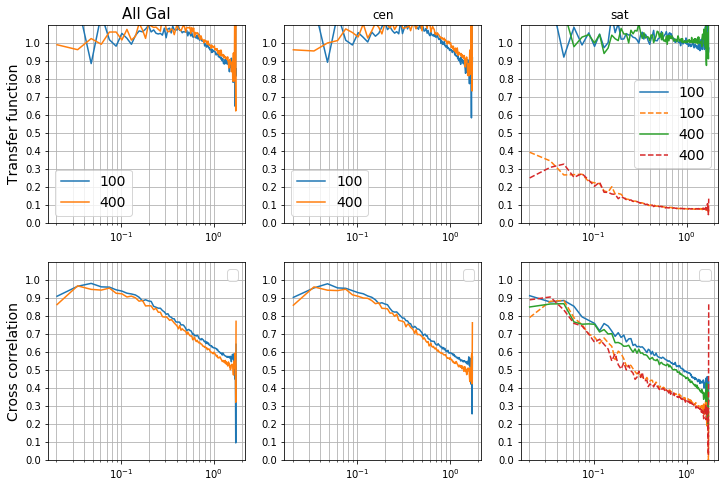

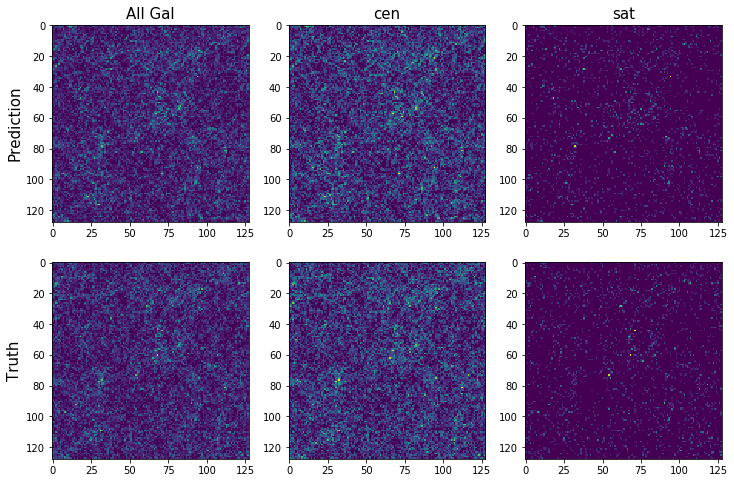

In [153]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(2, 3, figsize = (12, 8))
for seed in tseeds:
    for i, key in enumerate(['', 'cen', 'sat']):
        predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
        k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
        k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
        k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
    ##
        ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
        ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
        ax[0, i].set_title(key, fontsize=12)
    predict, hpmeshd = meshes[seed][0]['predict'] , meshes[seed][1]['pnnsat'],
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed, ls='--')
    ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5, ls='--')
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Transfer function', fontsize=14)
ax[1, 0].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, key in enumerate(['', 'cen', 'sat']):
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
    im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    ax[0, i].set_title(key, fontsize=15)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Prediction', fontsize=15)
ax[1, 0].set_ylabel('Truth', fontsize=15)
plt.show()


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


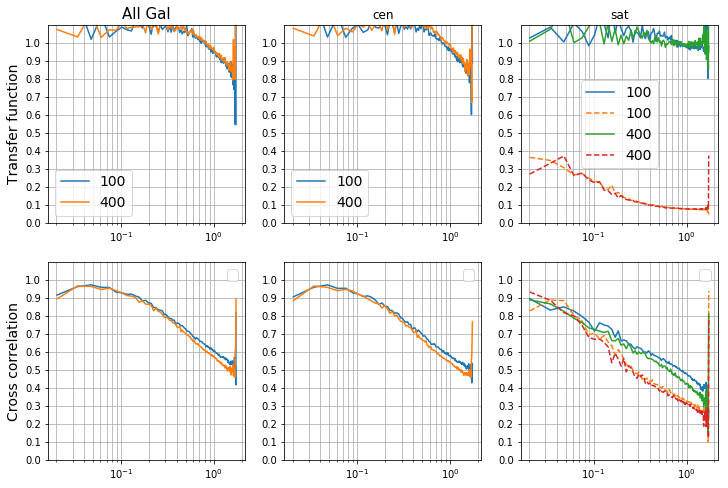

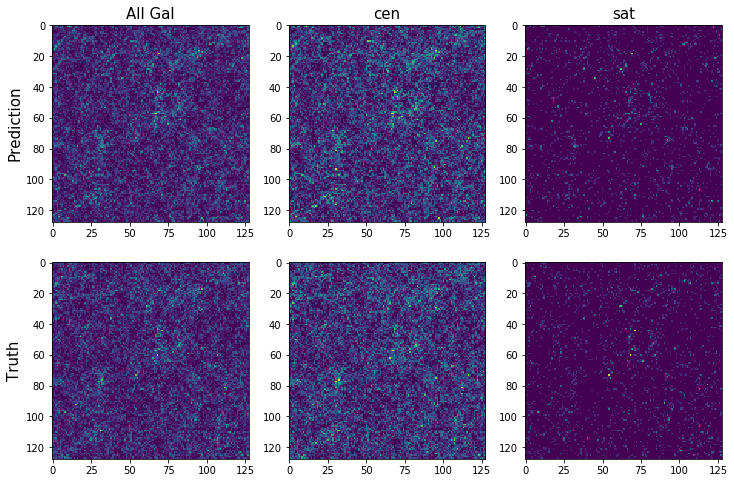

In [147]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(2, 3, figsize = (12, 8))
for seed in tseeds:
    for i, key in enumerate(['', 'cen', 'sat']):
        predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
        k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
        k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
        k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
    ##
        ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
        ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
        ax[0, i].set_title(key, fontsize=12)
    predict, hpmeshd = meshes[seed][0]['predict'] , meshes[seed][1]['pnnsat'],
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed, ls='--')
    ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5, ls='--')
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Transfer function', fontsize=14)
ax[1, 0].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, key in enumerate(['', 'cen', 'sat']):
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
    im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    ax[0, i].set_title(key, fontsize=15)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Prediction', fontsize=15)
ax[1, 0].set_ylabel('Truth', fontsize=15)
plt.show()


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


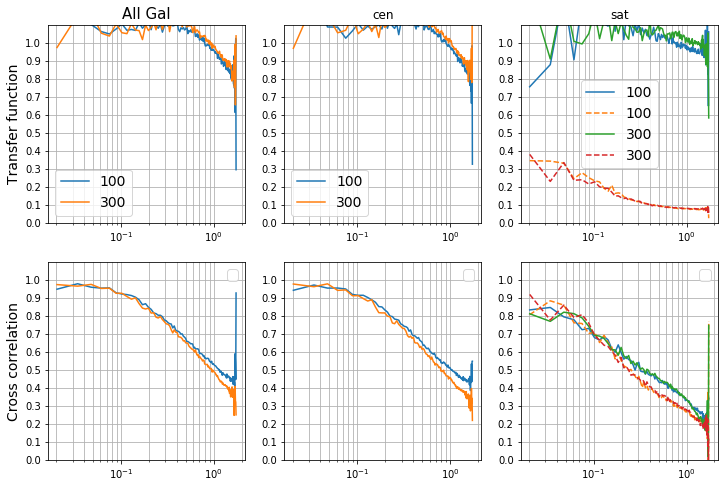

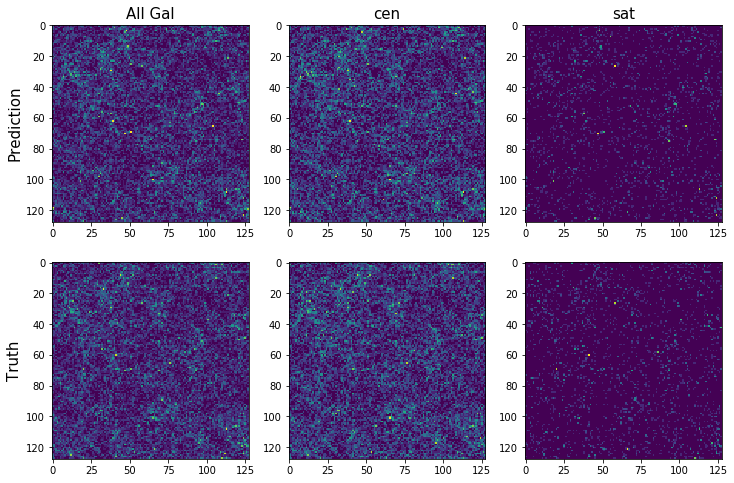

In [136]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(2, 3, figsize = (12, 8))
for seed in tseeds:
    for i, key in enumerate(['', 'cen', 'sat']):
        predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
        k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
        k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
        k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
    ##
        ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
        ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
        ax[0, i].set_title(key, fontsize=12)
    predict, hpmeshd = meshes[seed][0]['predict'] , meshes[seed][1]['pnnsat'],
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0, i].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed, ls='--')
    ax[1, i].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5, ls='--')
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Transfer function', fontsize=14)
ax[1, 0].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, key in enumerate(['', 'cen', 'sat']):
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
    vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
    im = ax[0, i].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    im = ax[1, i].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
    ax[0, i].set_title(key, fontsize=15)
ax[0, 0].set_title('All Gal', fontsize=15)
ax[0, 0].set_ylabel('Prediction', fontsize=15)
ax[1, 0].set_ylabel('Truth', fontsize=15)
plt.show()


/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


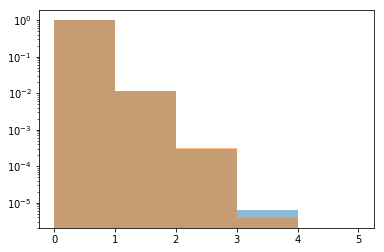

In [148]:
hist(meshes[seed][0]['predictcen'].flatten(),5,range=[0,5],normed=True,alpha=0.5);
hist(meshes[seed][1]['pnncen'].flatten(),5,range=[0,5],normed=True,alpha=0.5);
yscale('log')